In [11]:
%load_ext autoreload
%autoreload 2

In [1]:
import json
import pandas as pd
# Load JSON data from a file into a dictionary
df = pd.read_csv("results/csv/vnexpress_tuyensinh_13_6.csv")
df = df.fillna("")
# Display the dictionary

In [2]:
data = df.to_dict('records')

In [3]:
from backend.extractor.task.llm_downstream_utils import get_summarize_prompt, llm_get_tags
from backend.llm.llm import LLM

/Users/minhphan/anaconda3/envs/thesis-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module named 'fasttext'


In [7]:
data

[{'title': 'Thí sinh nghi ngờ điểm thi đánh giá năng lực của ĐH Quốc gia TP HCM',
  'article': 'Sau khi tra cứu điểm thi hôm 10/6, Phương Anh, học sinh lớp 12 ở Bình Dương, thấy vô lý khi chỉ đạt 16/300 điểm ở phần Khoa học Tự nhiên. Nữ sinh cho hay đã bàn với thầy cô về đáp án sau khi làm bài và chắc chắn đúng ít nhất 10 trong 30 câu ở phần này. Trao đổi với một số bạn cùng thi, Phương Anh nhận ra nhiều người gặp cảnh tương tự. "Trong số này, có một câu được tính điểm do đề bài sai, còn lại lẽ nào em không làm đúng thêm câu nào. Em nhớ rất rõ đáp án mình chọn nên nghi ngờ cách chấm điểm của Đại học Quốc gia TP HCM", Phương Anh nói. Khoảng 23h ngày 12/6, khi vào tài khoản xem lại thông tin để điền đơn phúc khảo, Phương Anh bất ngờ khi thấy điểm phần thi Khoa học Tự nhiên đã được điều chỉnh lên 150/300. Mạnh Hùng, thí sinh dự thi tại điểm trường Đại học Sư phạm Kỹ thuật TP HCM, cũng hoang mang khi điểm số nhận được lệch rất nhiều so với tính toán. Dò đáp án từ thầy giáo dạy thêm, Hùng c

In [44]:
# import uuid
# import pandas as pd
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud
# import re
# from underthesea import word_tokenize
# from langdetect import detect

# # from backend.extractor.task.nlp_tasks import create_word_cloud

# def remove_regex_patterns(text, regex_patterns):
#     combined_pattern = "|".join(regex_patterns)
#     filtered_text = re.sub(combined_pattern, "", text)
#     return filtered_text

# def prepare_word_cloud(
#     data,
#     selected_columns: list = None,
#     regex_patterns=None,
#     fixed_words=None,
# ):
#     test = "".join([value for value in data[0].values()])
#     lang_detect = detect(text)
#     if lang_detect == "vi":
#         with open("backend/llm/vietnamese_stopwords.txt", "r", encoding="utf-8") as file:
#             stopwords = set(file.read().splitlines())
#     else: 
#         with open("backend/llm/english_stopwords.txt", "r") as file:
#             stopwords = set(file.read().splitlines())
#     if selected_columns is None:
#         selected_columns = data[0].keys()
#     corpus = ""
#     for row in data:
#         for key, val in row.items():
#             row[key] = "" if val is None else val
#             if key in selected_columns:
#                 if regex_patterns is not None:
#                     text = remove_regex_patterns(text, regex_patterns)
#                 text = word_tokenize(val, format="text", fixed_words=fixed_words)
#                 print(text)
#                 text = text.lower()
#                 tokens = text.split()
#                 # Join the filtered tokens
#                 corpus += " ".join(tokens) + " "

#     # print("corpus", corpus)
#     # print(comment_words)

#     return corpus, stopwords


# def draw_word_cloud(data, stopwords, save=False):
#     wordcloud = WordCloud(
#         width=1200,
#         height=1200,
#         background_color="white",
#         stopwords=stopwords,
#         min_font_size=5,
#         font_step=1,
#     ).generate(data)

#     # Display WordCloud
#     plt.figure(figsize=(12, 12), facecolor=None)
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.tight_layout(pad=10)
#     plt.show()
#     img_id = str(uuid.uuid4())
#     save_path = ""
#     if save:
#         save_path = f"res/word_cloud/wordcloud_{img_id}.png"
#         plt.savefig(save_path)
#     return plt, save_path

2024-06-15 13:47:21,660 - llm_utils.py: prepare_word_cloud(): 147:	Preprocessing data
--------


data [{'title': 'Thí sinh nghi ngờ điểm thi đánh giá năng lực của ĐH Quốc gia TP HCM', 'article': 'Sau khi tra cứu điểm thi hôm 10/6, Phương Anh, học sinh lớp 12 ở Bình Dương, thấy vô lý khi chỉ đạt 16/300 điểm ở phần Khoa học Tự nhiên. Nữ sinh cho hay đã bàn với thầy cô về đáp án sau khi làm bài và chắc chắn đúng ít nhất 10 trong 30 câu ở phần này. Trao đổi với một số bạn cùng thi, Phương Anh nhận ra nhiều người gặp cảnh tương tự. "Trong số này, có một câu được tính điểm do đề bài sai, còn lại lẽ nào em không làm đúng thêm câu nào. Em nhớ rất rõ đáp án mình chọn nên nghi ngờ cách chấm điểm của Đại học Quốc gia TP HCM", Phương Anh nói. Khoảng 23h ngày 12/6, khi vào tài khoản xem lại thông tin để điền đơn phúc khảo, Phương Anh bất ngờ khi thấy điểm phần thi Khoa học Tự nhiên đã được điều chỉnh lên 150/300. Mạnh Hùng, thí sinh dự thi tại điểm trường Đại học Sư phạm Kỹ thuật TP HCM, cũng hoang mang khi điểm số nhận được lệch rất nhiều so với tính toán. Dò đáp án từ thầy giáo dạy thêm, Hùn

2024-06-15 13:47:22,783 - llm_utils.py: draw_word_cloud(): 103:	Generating word cloud
--------


Sáng 8/6 , khoảng 105.500 học_sinh ở Hà_Nội làm bài thi_môn Ngữ_văn , vắng gần 450 em . Theo Sở Giáo_dục_và_Đào_tạo Hà_Nội , trong số này , hai thí_sinh bị đình_chỉ vì mang điện_thoại vào phòng thi . Các em phải nộp lại bài làm , không được thi các buổi còn lại và bị hủy toàn_bộ kết_quả . Sở cho biết theo quy_chế , thí_sinh chỉ được mang theo bút viết , thước_kẻ , bút chì , tẩy , êke , thước_vẽ đồ_thị , dụng_cụ vẽ_hình , máy_tính cầm tay ( không có chức_năng soạn_thảo văn_bản và không có thẻ nhớ ) . Việc không mang điện_thoại vào phòng thi đã được cán_bộ , giáo_viên nhiều lần nhắc_nhở thí_sinh cả trước và trong khi làm thủ_tục thi . Sau bài thi Ngữ_văn , chiều nay , thí_sinh sẽ thi Ngoại_ngữ , chủ_yếu là Tiếng Anh . Ngày 9/6 , các em kết_thúc kỳ_thi với môn_Toán . Thí_sinh có nguyện_vọng vào hệ chuyên_thi thêm ngày 10/6 . Sở Giáo_dục_và_Đào_tạo cho biết 127 trường THPT công_lập ( gồm cả trường chuyên , trường tự_chủ ) sẽ tuyển 77.000 em . Điểm thi được công_bố chậm nhất vào ngày 2/7 , 

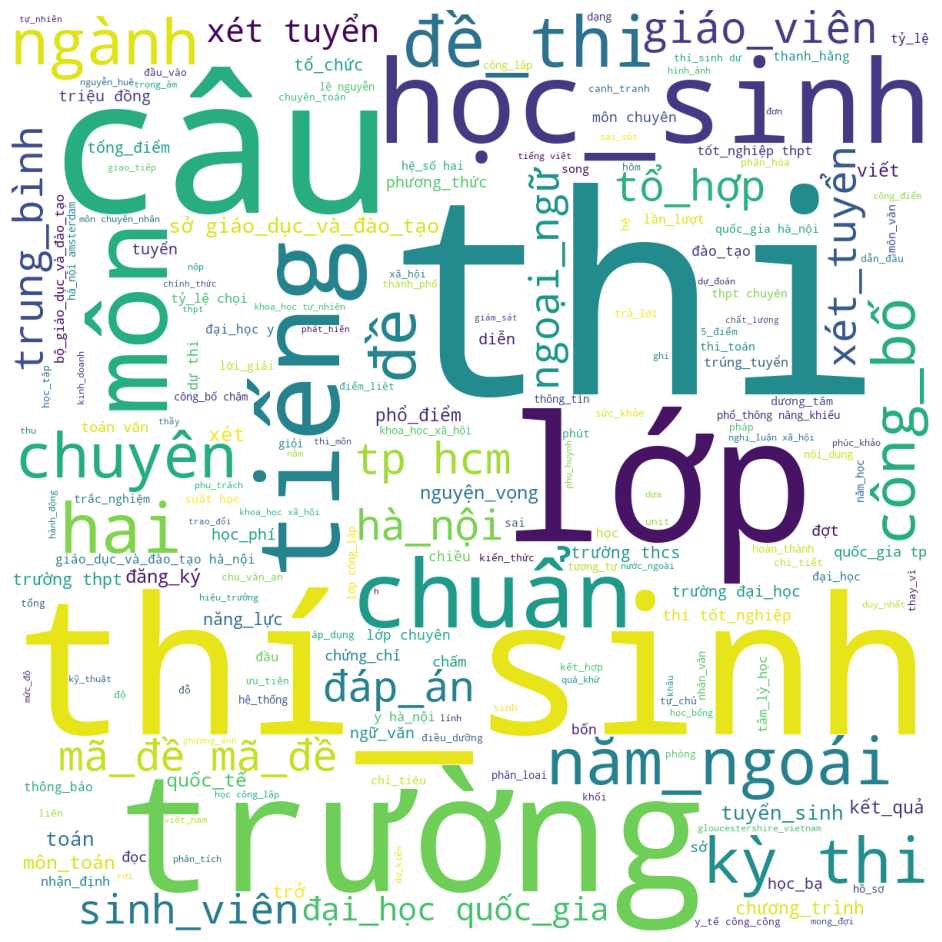

(<module 'matplotlib.pyplot' from '/Users/minhphan/anaconda3/envs/thesis-3.11/lib/python3.11/site-packages/matplotlib/pyplot.py'>,
 'results/word_cloud/wordcloud_be5168cb-6880-4255-8e79-65277f62f54f.png')

<Figure size 640x480 with 0 Axes>

In [16]:
# corpus, stopwords = prepare_word_cloud(data, selected_columns=["article"], fixed_words=["giáo dục và đào tạo", "đại học quốc gia hà nội", "đại học quốc gia tphcm", "đhqg tphcm", "đại học qg tp hcm", "đại học quốc gia tphcm", "phổ thông năng khiếu"])
from backend.extractor.task.nlp_tasks import create_word_cloud

create_word_cloud(
    data, selected_columns=["article"], regex_patterns=None, fixed_words=[], save=True
)

In [42]:
from langdetect import detect
lang = detect("Sau khi tra cứu điểm thi hôm 10/6 ")
print(lang)

vi


In [ ]:
# IUCFS

patterns = [
    r"#iu_\w+",
    r"\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}",
    r"[-~_][\w\s]*?[-~_]",
    r"[^\w\s]",
    r"sua dua",
]